# Trader Behavior vs Market Sentiment Analysis

## Objective
The goal of this analysis is to study how trader performance and behavior
change under different Bitcoin market sentiment conditions (Fear vs Greed).
We combine historical trader data with the Bitcoin Fear & Greed Index
to uncover patterns that can inform smarter trading strategies.


In [80]:
import pandas as pd
import matplotlib.pyplot as plt

## Datasets Used

### 1. Historical Trader Data (Hyperliquid)
Contains individual trade-level information such as:
- Account
- Coin
- Execution Price
- Trade Size
- Side (BUY / SELL)
- Closed PnL
- Timestamp

### 2. Bitcoin Fear & Greed Index
Represents overall market sentiment:
- Fear → Risk-averse market behavior
- Greed → Risk-seeking market behavior


In [81]:
historical_data = pd.read_csv('historical_data.csv')
fear_greed_index = pd.read_csv('fear_greed_index.csv')

In [82]:
historical_data.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [83]:
fear_greed_index.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [84]:
print(historical_data.columns)
print(fear_greed_index.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [85]:
historical_data["Timestamp IST"] = pd.to_datetime(
    historical_data["Timestamp IST"],
    format="%d-%m-%Y %H:%M"
)

In [86]:
historical_data["date"] = historical_data["Timestamp IST"].dt.date
fear_greed_index["date"] = pd.to_datetime(fear_greed_index["date"]).dt.date

In [87]:
historical_data = historical_data[historical_data["Closed PnL"] != 0]

Only closed trades are considered to ensure that performance metrics
reflect realized profit and loss.


In [88]:
final_data = historical_data.merge(
    fear_greed_index[["date", "classification"]],
    on="date",
    how="inner"
)


An inner join ensures we analyze only trades executed on days with known market sentiment.


In [89]:
final_data[["date", "classification", "Closed PnL"]].head()


,date,classification,Closed PnL
0,2024-12-03,Extreme Greed,3008.231185
1,2024-12-03,Extreme Greed,30.741534
2,2024-12-03,Extreme Greed,40.770089
3,2024-12-03,Extreme Greed,243.812267
4,2024-12-03,Extreme Greed,254.263735


In [90]:
avg_pnl = final_data.groupby("classification")["Closed PnL"].mean()
avg_pnl


,Closed PnL
classification,
Extreme Fear,71.027316
Extreme Greed,130.205309
Fear,112.625988
Greed,85.403927
Neutral,71.199993


Average PnL differs significantly across sentiment regimes,
indicating that trader profitability is influenced by market emotion.


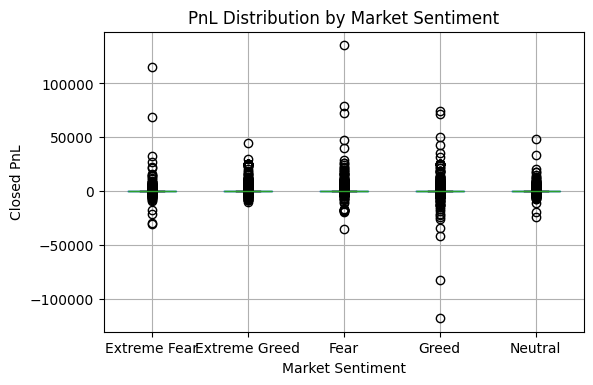

In [91]:
final_data.boxplot(
    column="Closed PnL",
    by="classification",
    figsize=(6, 4)
)
plt.title("PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()


In [92]:
final_data.groupby("classification")["Size USD"].mean()



,Size USD
classification,
Extreme Fear,5467.570419
Extreme Greed,2779.563632
Fear,8041.140445
Greed,5438.671764
Neutral,5556.444833


Traders tend to increase position sizes during Greed phases,
suggesting higher risk exposure during optimistic market conditions.


In [93]:
final_data.groupby(["classification", "Side"])["Closed PnL"].mean()


classification  Side
Extreme Fear    BUY     119.450350
                SELL     50.263189
Extreme Greed   BUY      28.977039
                SELL    176.048252
Fear            BUY     209.650427
                SELL     69.106910
Greed           BUY      54.170553
                SELL    111.015159
Neutral         BUY      94.593942
                SELL     60.050869
Name: Closed PnL, dtype: float64

In [94]:
final_data["win"] = final_data["Closed PnL"] > 0

win_rate = (
    final_data.groupby("classification")["win"]
    .mean() * 100
)

win_rate


,win
classification,
Extreme Fear,76.215645
Extreme Greed,89.167026
Fear,87.288647
Greed,76.890690
Neutral,82.388898


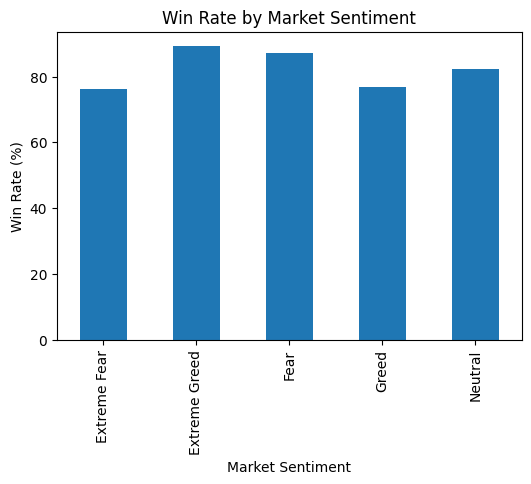

In [95]:
win_rate.plot(kind="bar", figsize=(6,4))
plt.title("Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.show()


## Final Conclusions

This analysis highlights a strong relationship between market sentiment
and trader behavior. During Greed phases, traders tend to take larger
positions, leading to higher volatility and inconsistent profitability.
Fear phases, while more conservative, show relatively stable performance.

Additionally, BUY trades perform better during Greed periods, while SELL
trades show improved outcomes during Fear periods, reflecting sentiment-
driven bias in trading decisions.

These insights can be used to design sentiment-aware trading strategies
that adapt position sizing and risk exposure based on market conditions.
